In [1]:
pip install pymssql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 30.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!curl ifconfig.me

104.196.133.247

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sqlalchemy import create_engine
import re

In [4]:
# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text using SpaCy
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])



In [5]:
server = 'waly.database.windows.net'
database = 'customer feedback'  # Your database name
username = 'sqladmin'
password = 'Depiproject#'

# Create the connection URL using pymssql
connection_url = f"mssql+pymssql://{username}:{password}@{server}/{database}"

# Create the SQLAlchemy engine
engine = create_engine(connection_url)

# Example: Read data into a DataFrame
query = """
    select top(60000) * 
    from Feedback
    where score = 5
    union 
    select top(20000) * 
    from Feedback
    where score = 4
    union 
    select * 
    from Feedback
    where score = 2 or score = 1
"""  # Replace 'Feedback' with your actual table name

# Use the engine to connect and read the data
df = pd.read_sql(query, engine)

# Display the data
print(df.head())

# Close the engine
engine.dispose()


   FeedbackId   ProductId          UserId  HelpfulnessNumerator  \
0           1  B001E4KFG0  A3SGXH7AUHU8GW                     1   
1           5  B006K2ZZ7K  A1UQRSCLF8GW1T                     0   
2           7  B006K2ZZ7K  A1SP2KVKFXXRU1                     0   
3           8  B006K2ZZ7K  A3JRGQVEQN31IQ                     0   
4           9  B000E7L2R4  A1MZYO9TZK0BBI                     1   

   HelpfulnessDenominator  Score       Time  \
0                       1      5 2011-04-27   
1                       0      5 2012-10-21   
2                       0      5 2012-06-20   
3                       0      5 2012-05-03   
4                       1      5 2011-11-23   

                                         summary  \
0                          Good Quality Dog Food   
1                                    Great taffy   
2  Great!  Just as good as the expensive brands!   
3                       "Wonderful, tasty taffy"   
4                                     Yay Barley   

 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162037 entries, 0 to 162036
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   FeedbackId              162037 non-null  int64         
 1   ProductId               162037 non-null  object        
 2   UserId                  162037 non-null  object        
 3   HelpfulnessNumerator    162037 non-null  int64         
 4   HelpfulnessDenominator  162037 non-null  int64         
 5   Score                   162037 non-null  int64         
 6   Time                    162037 non-null  datetime64[ns]
 7   summary                 162037 non-null  object        
 8   text                    162037 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 11.1+ MB


In [7]:
df.head(15)

,FeedbackId,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,summary,text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,2012-10-21,Great taffy,"""Great taffy at a great price. There was a wi..."
2,7,B006K2ZZ7K,A1SP2KVKFXXRU1,0,0,5,2012-06-20,Great! Just as good as the expensive brands!,"""This saltwater taffy had great flavors and wa..."
3,8,B006K2ZZ7K,A3JRGQVEQN31IQ,0,0,5,2012-05-03,"""Wonderful, tasty taffy""",This taffy is so good. It is very soft and ch...
4,9,B000E7L2R4,A1MZYO9TZK0BBI,1,1,5,2011-11-23,Yay Barley,Right now I'm mostly just sprouting this so my...
5,10,B00171APVA,A21BT40VZCCYT4,0,0,5,2012-10-26,Healthy Dog Food,This is a very healthy dog food. Good for thei...
6,11,B0001PB9FE,A3HDKO7OW0QNK4,1,1,5,2005-02-08,The Best Hot Sauce in the World,"""I don't know if it's the cactus or the tequil..."
7,12,B0009XLVG0,A2725IB4YY9JEB,4,4,5,2010-08-27,"""My cats LOVE this """"diet"""" food better than t...","""One of my boys needed to lose some weight and..."
8,15,B001GVISJM,A2MUGFV2TDQ47K,4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...
9,16,B001GVISJM,A1CZX3CP8IKQIJ,4,5,5,2009-12-29,"""Lots of twizzlers, just what you expect.""",My daughter loves twizzlers and this shipment ...


In [8]:
df.drop(columns=["FeedbackId","ProductId", "UserId", "HelpfulnessDenominator", "Time"], inplace=True)

In [9]:
# Count the number of null values in each column
null_counts = df.isnull().sum()
null_counts

HelpfulnessNumerator    0
Score                   0
summary                 0
text                    0
dtype: int64

In [10]:
def clean_text(text):
    text = re.sub(r'^["\']+', '', text)
    text = re.sub(r'["\']+$', '', text)
    return text

In [11]:
df['summary'] = df['summary'].apply(clean_text)
df['text'] = df['text'].apply(clean_text)

In [12]:
#for simplicity
df['summary'] = df['summary'].str.lower()
df['text'] = df['text'].str.lower()

In [13]:
df

,HelpfulnessNumerator,Score,summary,text
0,1,5,good quality dog food,i have bought several of the vitality canned d...
1,0,5,great taffy,great taffy at a great price. there was a wid...
2,0,5,great! just as good as the expensive brands!,this saltwater taffy had great flavors and was...
3,0,5,"wonderful, tasty taffy",this taffy is so good. it is very soft and ch...
4,1,5,yay barley,right now i'm mostly just sprouting this so my...
...,...,...,...,...
162032,0,1,tastes horrible!,i just bought this soup today at my local groc...
162033,0,2,not so good,this soup is mostly broth. although it has a k...
162034,0,2,where's the tortellini?,"it is mostly broth, with the advertised 3/4 cu..."
162035,0,2,mixed wrong,i had ordered some of these a few months back ...


In [14]:
def classify_sentiment(score):
    if score >= 3:
        return 'positive'
    else:
        return 'negative'

In [15]:
# Apply classification to the 'Score' column
df['sentiment'] = df['Score'].apply(classify_sentiment)

# Encode the target labels using LabelEncoder
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [16]:
# Display the processed data with sentiment labels
df[['text', 'sentiment', 'sentiment_encoded']].head()

,text,sentiment,sentiment_encoded
0,i have bought several of the vitality canned d...,positive,1
1,great taffy at a great price. there was a wid...,positive,1
2,this saltwater taffy had great flavors and was...,positive,1
3,this taffy is so good. it is very soft and ch...,positive,1
4,right now i'm mostly just sprouting this so my...,positive,1


In [17]:
# Features and target
X = df['text'].values
y = df['sentiment_encoded'].values

# Tokenization using Keras Tokenizer
tokenizer = Tokenizer(num_words=5000, lower=True, oov_token='OOV')
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)



In [18]:
# Pad sequences to ensure uniform input length
X_padded = pad_sequences(X_tokenized, maxlen=100)

# Ensure y has sufficient samples
print("Shape of y:", y.shape)  # Check shape of y

# Set the train size to 110,000 samples, less than or equal to the total number of samples
train_size = min(110000, y.shape[0])

# Split the dataset into training and remaining data
X_train, X_rem, y_train, y_rem = train_test_split(
    X_padded, y, train_size=train_size, random_state=42
)

# Debug: Check shapes after the first split
print("After training split:")
print("X_rem shape:", X_rem.shape)  # Should show (total_samples - train_size, 100)
print("y_rem shape:", y_rem.shape)  # Should show (total_samples - train_size,)

# Now, split the remaining data into validation and test sets
# We need 25,000 for validation and 25,000 for testing
valid_size = min(25000, y_rem.shape[0])
test_size = min(25000, y_rem.shape[0] - valid_size)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_rem, y_rem, test_size=test_size, random_state=42
)

# Check the shapes to ensure everything is correct
print("Shapes after validation and test split:")
print("X_train shape:", X_train.shape)  # Should be (110000, 100)
print("y_train shape:", y_train.shape)  # Should be (110000,)
print("X_valid shape:", X_valid.shape)  # Should be (25000, 100)
print("y_valid shape:", y_valid.shape)  # Should be (25000,)
print("X_test shape:", X_test.shape)    # Should be (25000, 100)
print("y_test shape:", y_test.shape)    # Should be (25000,)


Shape of y: (162037,)
After training split:
X_rem shape: (52037, 100)
y_rem shape: (52037,)
Shapes after validation and test split:
X_train shape: (110000, 100)
y_train shape: (110000,)
X_valid shape: (27037, 100)
y_valid shape: (27037,)
X_test shape: (25000, 100)
y_test shape: (25000,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense


In [21]:
# Update model to have a single output unit with sigmoid activation
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(256, dropout=0.5, recurrent_dropout=0.3, return_sequences=True)))

# Second Bidirectional LSTM layer with return_sequences=False
model.add(Bidirectional(LSTM(128, dropout=0.4, recurrent_dropout=0.3, return_sequences=False)))

# Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))  # Single output for binary classification


In [22]:
print(X_train.shape)
print(y_train.shape)


(110000, 100)
(110000,)


In [23]:
print(X_test.shape)
print(y_test.shape)


(25000, 100)
(25000,)


In [24]:
from tensorflow.keras.metrics import Precision, Recall
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [25]:
# Train the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=5, 
    batch_size=256, 
    validation_data=(X_valid, y_valid), 
    verbose=2
)

Epoch 1/5
430/430 - 1191s - 3s/step - accuracy: 0.8038 - loss: 0.4191 - precision: 0.8123 - recall: 0.7841 - val_accuracy: 0.8738 - val_loss: 0.2984 - val_precision: 0.9093 - val_recall: 0.8249
Epoch 2/5
430/430 - 1239s - 3s/step - accuracy: 0.8749 - loss: 0.3054 - precision: 0.8820 - recall: 0.8622 - val_accuracy: 0.8860 - val_loss: 0.2818 - val_precision: 0.8674 - val_recall: 0.9061
Epoch 3/5
430/430 - 1258s - 3s/step - accuracy: 0.8869 - loss: 0.2809 - precision: 0.8928 - recall: 0.8764 - val_accuracy: 0.8931 - val_loss: 0.2617 - val_precision: 0.9117 - val_recall: 0.8659
Epoch 4/5
430/430 - 1241s - 3s/step - accuracy: 0.8935 - loss: 0.2673 - precision: 0.8992 - recall: 0.8836 - val_accuracy: 0.8969 - val_loss: 0.2564 - val_precision: 0.8983 - val_recall: 0.8905
Epoch 5/5
430/430 - 1186s - 3s/step - accuracy: 0.8989 - loss: 0.2556 - precision: 0.9055 - recall: 0.8881 - val_accuracy: 0.8993 - val_loss: 0.2544 - val_precision: 0.8908 - val_recall: 0.9056


In [28]:
# Predict and generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report using Scikit-learn
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, zero_division=1))


782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step
              precision    recall  f1-score   support

    negative       0.50      1.00      0.67     12614
    positive       1.00      0.00      0.00     12386

    accuracy                           0.50     25000
   macro avg       0.75      0.50      0.34     25000
weighted avg       0.75      0.50      0.34     25000



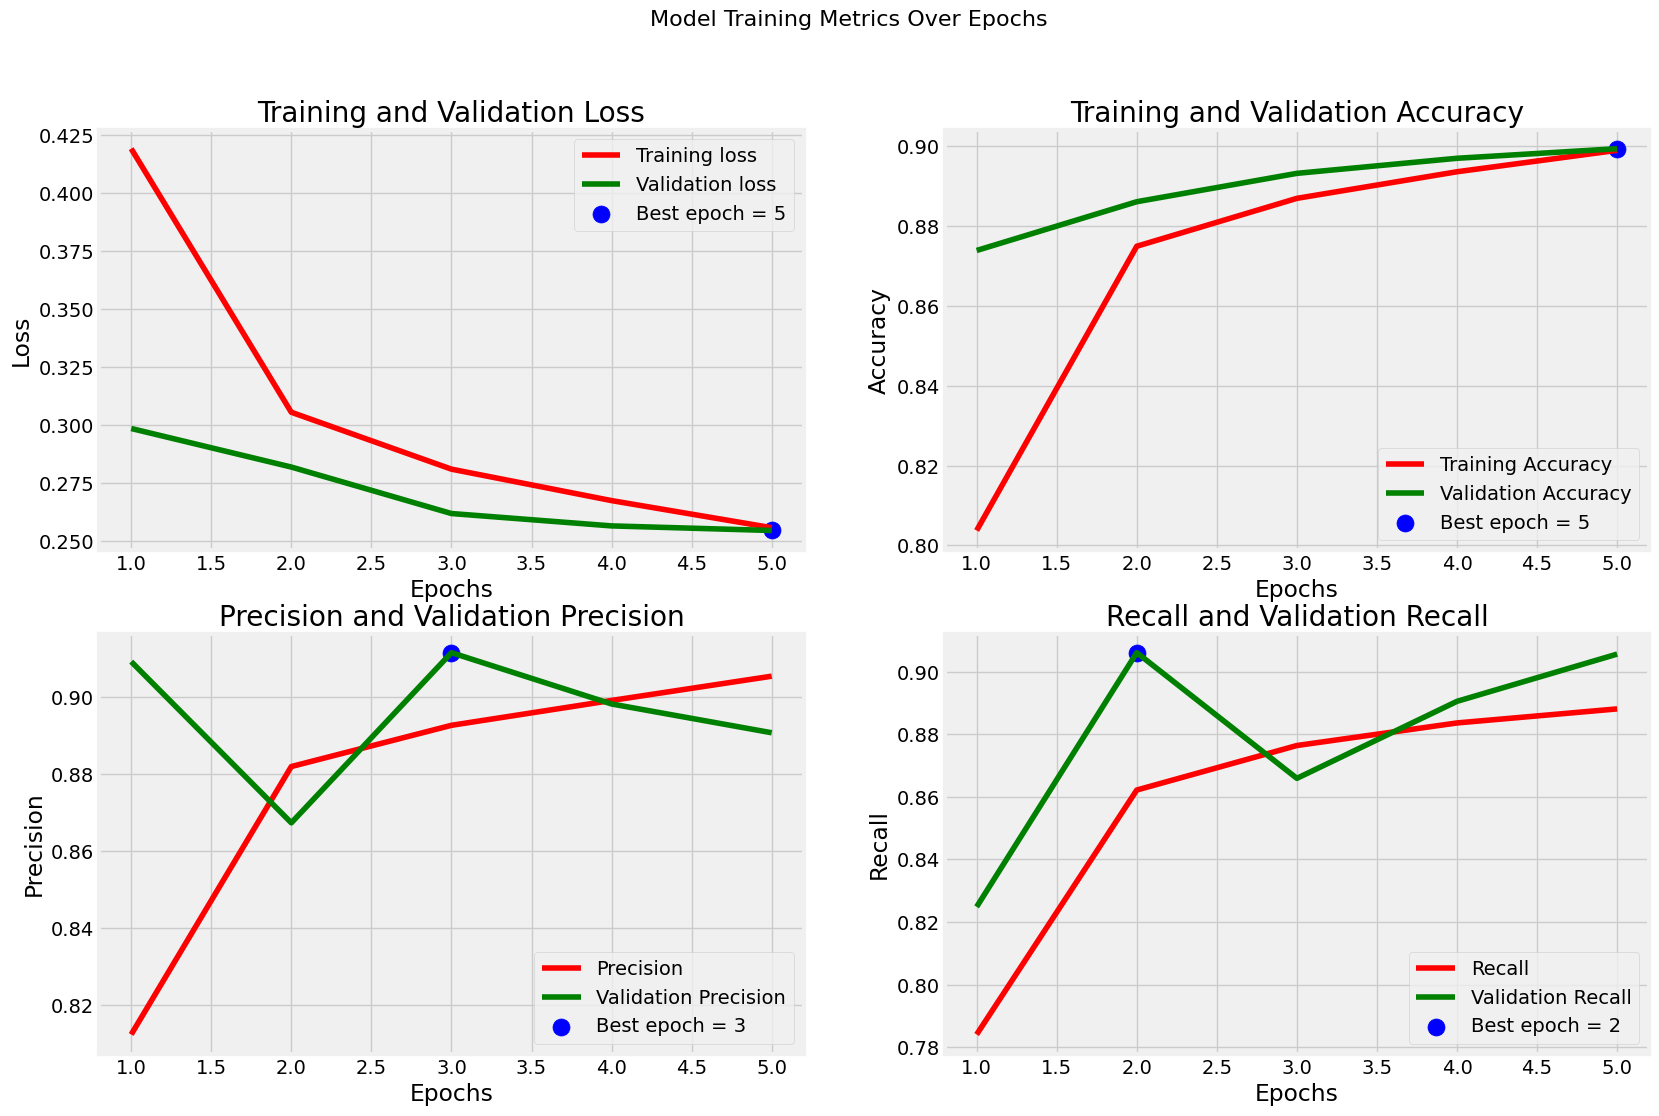

In [31]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
tr_per = history.history['precision']
tr_recall = history.history['recall']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
val_per = history.history['val_precision']
val_recall = history.history['val_recall']

# Indices for the best epochs
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Epochs list
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Plotting
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [32]:
model.save('my_model.h5')

In [33]:
import pickle

with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


In [34]:
import numpy as np
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Load the trained model
model = load_model('my_model.h5')

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

# Define sentiment labels
LABELS = {0: "Negative", 1: "Positive"}

# Set a custom threshold for positive sentiment
CUSTOM_THRESHOLD = 0.5

def predict_sentiment(text):
    """
    Predict the sentiment of the input text.

    Args:
        text (str): The input text to analyze.

    Returns:
        str: The predicted sentiment label ("Negative" or "Positive").
    """
    # Tokenize the input text
    sequences = tokenizer.texts_to_sequences([text])
    
    # Pad the sequences
    padded_sequence = pad_sequences(sequences, maxlen=100)  # Ensure the same length as training

    # Predict the sentiment
    prediction = model.predict(padded_sequence)

    # Get the predicted probabilities
    predicted_probability = prediction[0][0]  # Assuming binary classification with a single output node

    # Determine sentiment label based on threshold
    if predicted_probability >= CUSTOM_THRESHOLD:
        sentiment_label = "Positive"
    else:
        sentiment_label = "Negative"

    # Print the predicted probability for debugging
    print(f"Predicted probability: {predicted_probability}")

    return sentiment_label


In [35]:
# Example usage
text_good = "My keyboard takes up 90% of the space and I have no space to move my mouse and gets very dirty"
predicted_sentiment_good = predict_sentiment(text_good)

print(f"Sentiment for good text: {predicted_sentiment_good}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
Predicted probability: 0.2883596122264862
Sentiment for good text: Negative
